# Cake Eating II: Numerical Methods

```{contents} Contents
:depth: 2
```

## Overview

In this lecture we continue the study of {doc}`the cake eating problem <cake_eating>`.

The aim of this lecture is to solve the problem using numerical
methods.

At first this might appear unnecessary, since we already obtained the optimal
policy analytically.

However, the cake eating problem is too simple to be useful without
modifications, and once we start modifying the problem, numerical methods become essential.

Hence it makes sense to introduce numerical methods now, and test them on this
simple problem.

Since we know the analytical solution, this will allow us to assess the
accuracy of alternative numerical methods.


```{note}
The code below aims for clarity rather than maximum efficiency.

In the lectures below we will explore best practice for speed and efficiency.

Let's put these algorithm and code optimizations to one side for now.
```

We will use the following imports:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize_scalar, bisect
from typing import NamedTuple

## Reviewing the Model

You might like to {doc}`review the details <cake_eating>` before we start.

Recall in particular that the Bellman equation is

```{math}
:label: bellman-cen

v(x) = \max_{0\leq c \leq x} \{u(c) + \beta v(x-c)\}
\quad \text{for all } x \geq 0.
```

where $u$ is the CRRA utility function.

The analytical solutions for the value function and optimal policy were found
to be as follows.

In [2]:
def c_star(x, β, γ):

    return (1 - β ** (1/γ)) * x


def v_star(x, β, γ):

    return (1 - β**(1 / γ))**(-γ) * (x**(1-γ) / (1-γ))

Our first aim is to obtain these analytical solutions numerically.

## Value Function Iteration

The first approach we will take is **value function iteration**.

This is a form of **successive approximation**, and was discussed in our {doc}`lecture on job search <mccall_model>`.

The basic idea is:

1. Take an arbitrary initial guess of $v$.
1. Obtain an update $w$ defined by

   $$
       w(x) = \max_{0\leq c \leq x} \{u(c) + \beta v(x-c)\}
   $$

1. Stop if $w$ is approximately equal to $v$, otherwise set
   $v=w$ and go back to step 2.

Let's write this a bit more mathematically.

### The Bellman Operator

We introduce the **Bellman operator** $T$ that takes a function v as an
argument and returns a new function $Tv$ defined by

$$
Tv(x) = \max_{0 \leq c \leq x} \{u(c) + \beta v(x - c)\}
$$

From $v$ we get $Tv$, and applying $T$ to this yields
$T^2 v := T (Tv)$ and so on.

This is called **iterating with the Bellman operator** from initial guess
$v$.

As we discuss in more detail in later lectures, one can use Banach's
contraction mapping theorem to prove that the sequence of functions $T^n
v$ converges to the solution to the Bellman equation.

### Fitted Value Function Iteration

Both consumption $c$ and the state variable $x$ are continuous.

This causes complications when it comes to numerical work.

For example, we need to store each function $T^n v$ in order to
compute the next iterate $T^{n+1} v$.

But this means we have to store $T^n v(x)$ at infinitely many $x$, which is, in general, impossible.

To circumvent this issue we will use fitted value function iteration, as
discussed previously in {doc}`one of the lectures <mccall_fitted_vfi>` on job
search.

The process looks like this:

1. Begin with an array of values $\{ v_0, \ldots, v_I \}$  representing
   the values of some initial function $v$ on the grid points $\{ x_0, \ldots, x_I \}$.
1. Build a function $\hat v$ on the state space $\mathbb R_+$ by
   interpolation, based on the interpolation points $\{(x_i, v_i)\}$.
1. Insert $\hat v$ into the right hand side of the Bellman equation and
   obtain and record the value $T \hat v(x_i)$ on each grid point
   $x_i$.
1. Unless some stopping condition is satisfied, set
   $\{ v_0, \ldots, v_I \} = \{ T \hat v(x_0), \ldots, T \hat v(x_I) \}$ and go to step 2.

In step 2 we'll use piecewise linear interpolation.



### Implementation

The `maximize` function below is a small helper function that converts a
SciPy minimization routine into a maximization routine.

In [3]:
def maximize(g, a, b, args):
    """
    Maximize the function g over the interval [a, b].

    We use the fact that the maximizer of g on any interval is
    also the minimizer of -g.  The tuple args collects any extra
    arguments to g.

    Returns the maximal value and the maximizer.
    """

    objective = lambda x: -g(x, *args)
    result = minimize_scalar(objective, bounds=(a, b), method='bounded')
    maximizer, maximum = result.x, -result.fun
    return maximizer, maximum

We'll store the parameters $\beta$ and $\gamma$ and the grid in a
`NamedTuple` called `Model`.

We'll also create a helper function called `create_cake_eating_model` to store
default parameters and build an instance of `Model`.

In [4]:
class Model(NamedTuple):
    β: float
    γ: float
    x_grid: np.ndarray

def create_cake_eating_model(
        β: float = 0.96,           # discount factor
        γ: float = 1.5,            # degree of relative risk aversion
        x_grid_min: float = 1e-3,  # exclude zero for numerical stability
        x_grid_max: float = 2.5,   # size of cake
        x_grid_size: int = 120
    ):
    """
    Creates an instance of the cake eating model.

    """
    x_grid = np.linspace(x_grid_min, x_grid_max, x_grid_size)
    return Model(β, γ, x_grid)

Here's the CRRA utility function.

In [5]:
def u(c, γ):
    """
    Utility function.
    """
    if γ == 1:
        return np.log(c)
    else:
        return (c ** (1 - γ)) / (1 - γ)

The next function is the unmaximized right hand side of the Bellman equation.

The array `v` is the current guess of $v$, stored as an array on the grid
points.

In [6]:
def state_action_value(
        c: float,               # current consumption
        x: float,               # the current state (remaining cake)
        v: np.ndarray,          # current guess of the value function
        model: Model            # instance of cake eating model
    ):
    """
    Right hand side of the Bellman equation given x and c.

    """
    # Unpack
    β, γ, x_grid = model.β, model.γ, model.x_grid
    # Convert array into function
    vf = lambda x: np.interp(x, x_grid, v)
    # Return unmaximmized RHS of Bellman equation 
    return u(c, γ) + β * vf(x - c)

We now define the Bellman operation:

In [7]:
def T(
        v: np.ndarray,          # current guess of the value function
        model: Model            # instance of cake eating model
    ):
    """
    The Bellman operator.  Updates the guess of the value function.

    """
    v_new = np.empty_like(v)

    for i, x in enumerate(model.x_grid):
        # Maximize RHS of Bellman equation at state x
        v_new[i] = maximize(state_action_value, 1e-10, x, (x, v, model))[1]

    return v_new

After defining the Bellman operator, we are ready to solve the model.

Let's start by creating a model using the default parameterization.

In [8]:
model = create_cake_eating_model()

Now let's see the iteration of the value function in action.

We start from guess $v$ given by $v(x) = u(x)$ for every
$x$ grid point.

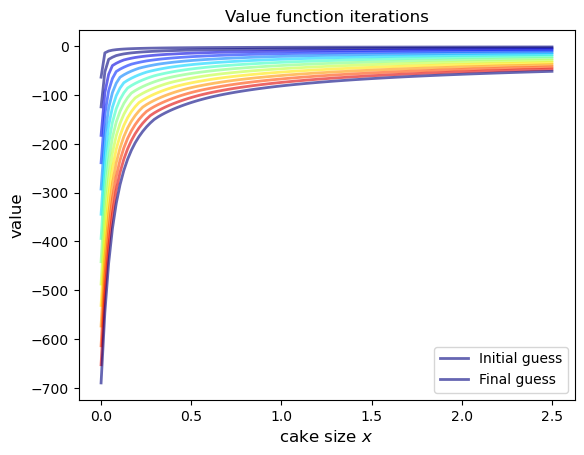

In [9]:
x_grid = model.x_grid
v = u(x_grid, model.γ)  # Initial guess
n = 12                  # Number of iterations
fig, ax = plt.subplots()

# Initial plot
ax.plot(x_grid, v, color=plt.cm.jet(0),
        lw=2, alpha=0.6, label='Initial guess')

# Iterate
for i in range(n):
    v = T(v, model)  # Apply the Bellman operator
    ax.plot(x_grid, v, color=plt.cm.jet(i / n), lw=2, alpha=0.6)

# One last update and plot
v = T(v, model)  
ax.plot(x_grid, v, color=plt.cm.jet(0),
        lw=2, alpha=0.6, label='Final guess')

ax.legend()
ax.set_ylabel('value', fontsize=12)
ax.set_xlabel('cake size $x$', fontsize=12)
ax.set_title('Value function iterations')
plt.show()

To iterate more systematically, we introduce a wrapper function called
`compute_value_function`.

It's task is to iterate using $T$ until some convergence conditions are satisfied.

In [10]:
def compute_value_function(
        model: Model,
        tol: float = 1e-4,
        max_iter: int = 1_000,
        verbose: bool = True,
        print_skip: int = 25
    ):

    # Set up loop
    v = np.zeros(len(model.x_grid)) # Initial guess
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_new = T(v, model)

        error = np.max(np.abs(v - v_new))
        i += 1

        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")

        v = v_new

    if error > tol:
        print("Failed to converge!")
    elif verbose:
        print(f"\nConverged in {i} iterations.")

    return v_new

Now let's call it, noting that it takes a little while to run.

In [11]:
v = compute_value_function(model)

Error at iteration 25 is 23.8003755134813.
Error at iteration 50 is 8.577577195046615.
Error at iteration 75 is 3.091330659691039.
Error at iteration 100 is 1.1141054204751981.
Error at iteration 125 is 0.4015199357729671.
Error at iteration 150 is 0.14470646660561215.
Error at iteration 175 is 0.052151735472762084.
Error at iteration 200 is 0.018795314242879613.
Error at iteration 225 is 0.006773769545588948.
Error at iteration 250 is 0.0024412443051460286.
Error at iteration 275 is 0.0008798164327572522.
Error at iteration 300 is 0.00031708295392718355.
Error at iteration 325 is 0.00011427565573285392.

Converged in 329 iterations.


Error at iteration 50 is 8.577577195046615.


Error at iteration 75 is 3.091330659691039.


Error at iteration 100 is 1.1141054204751981.


Error at iteration 125 is 0.4015199357729671.


Error at iteration 150 is 0.14470646660561215.


Error at iteration 175 is 0.052151735472762084.


Error at iteration 200 is 0.018795314242879613.


Error at iteration 225 is 0.006773769545588948.


Error at iteration 250 is 0.0024412443051460286.


Error at iteration 275 is 0.0008798164327572522.


Error at iteration 300 is 0.00031708295392718355.


Error at iteration 325 is 0.00011427565573285392.



Converged in 329 iterations.


Now we can plot and see what the converged value function looks like.

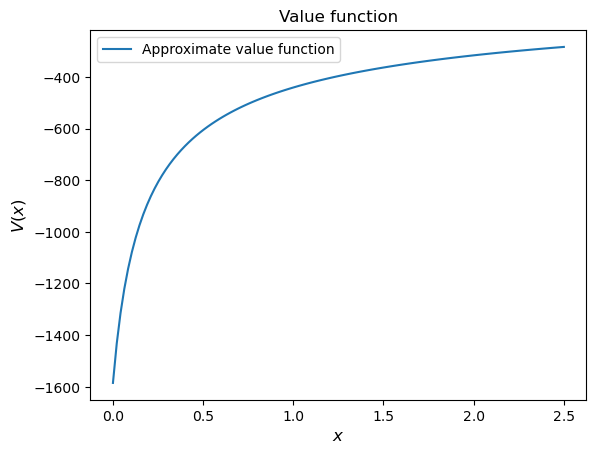

In [12]:
fig, ax = plt.subplots()

ax.plot(x_grid, v, label='Approximate value function')
ax.set_ylabel('$V(x)$', fontsize=12)
ax.set_xlabel('$x$', fontsize=12)
ax.set_title('Value function')
ax.legend()
plt.show()

Next let's compare it to the analytical solution.

In [13]:
v_analytical = v_star(model.x_grid, model.β, model.γ)

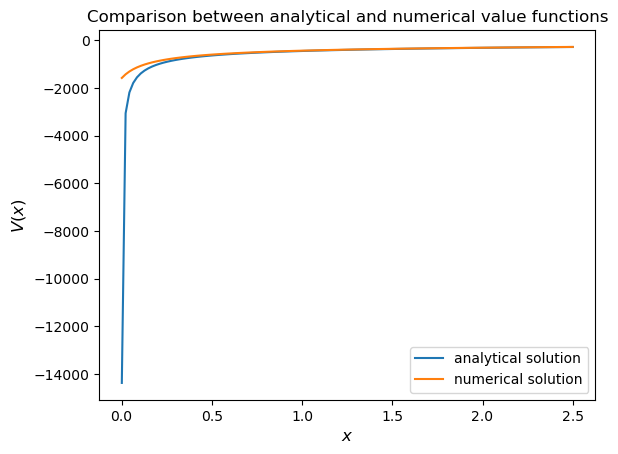

In [14]:
fig, ax = plt.subplots()

ax.plot(x_grid, v_analytical, label='analytical solution')
ax.plot(x_grid, v, label='numerical solution')
ax.set_ylabel('$V(x)$', fontsize=12)
ax.set_xlabel('$x$', fontsize=12)
ax.legend()
ax.set_title('Comparison between analytical and numerical value functions')
plt.show()

The quality of approximation is reasonably good for large $x$, but
less so near the lower boundary.

The reason is that the utility function and hence value function is very
steep near the lower boundary, and hence hard to approximate.

```{note}
One way to fix this issue is to use a nonlinear grid, with more points in the
neighborhood of zero.

Instead of pursuing this idea, however, we will turn our attention to 
working with policy functions.

We will see that value function iteration can be avoided by iterating on a guess
of the policy function instead.  

The policy function has less curvature and hence is easier to interpolate than
the value function.

These ideas will be explored over the next few lectures.
```


### Policy Function

Let's try computing the optimal policy.

In the {doc}`first lecture on cake eating <cake_eating>`, the optimal
consumption policy was shown to be

$$
    \sigma^*(x) = \left(1-\beta^{1/\gamma} \right) x
$$

Let's see if our numerical results lead to something similar.

Our numerical strategy will be to compute

$$
\sigma(x) = \arg \max_{0 \leq c \leq x} \{u(c) + \beta v(x - c)\}
$$

on a grid of $x$ points and then interpolate.

For $v$ we will use the approximation of the value function we obtained
above.

Here's the function:

In [15]:
def σ(
        v: np.ndarray,          # current guess of the value function
        model: Model            # instance of cake eating model
    ):
    """
    The optimal policy function. Given the value function,
    it finds optimal consumption in each state.

    """
    c = np.empty_like(v)

    for i in range(len(model.x_grid)):
        x = model.x_grid[i]
        # Maximize RHS of Bellman equation at state x
        c[i] = maximize(state_action_value, 1e-10, x, (x, v, model))[0]

    return c

Now let's pass the approximate value function and compute optimal consumption:

In [16]:
c = σ(v, model)

(pol_an)=
Let's plot this next to the true analytical solution

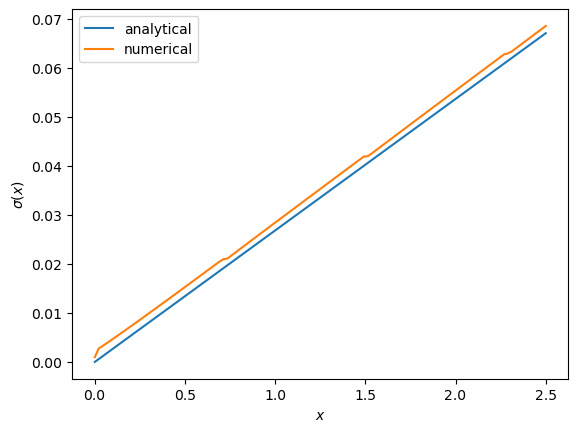

In [17]:
c_analytical = c_star(model.x_grid, model.β, model.γ)

fig, ax = plt.subplots()

ax.plot(model.x_grid, c_analytical, label='analytical')
ax.plot(model.x_grid, c, label='numerical')
ax.set_ylabel(r'$\sigma(x)$')
ax.set_xlabel('$x$')
ax.legend()

plt.show()

The fit is reasonable but not perfect.

We can improve it by increasing the grid size or reducing the
error tolerance in the value function iteration routine.

However, both changes will lead to a longer compute time.

Another possibility is to use an alternative algorithm, which offers the
possibility of faster compute time and, at the same time, more accuracy.

We explore this {doc}`soon <cake_eating_time_iter>`.


## Exercises

```{exercise}
:label: cen_ex1

Try the following modification of the problem.

Instead of the cake size changing according to $x_{t+1} = x_t - c_t$,
let it change according to

$$
x_{t+1} = (x_t - c_t)^{\alpha}
$$

where $\alpha$ is a parameter satisfying $0 < \alpha < 1$.

(We will see this kind of update rule when we study optimal growth models.)

Make the required changes to value function iteration code and plot the value and policy functions.

Try to reuse as much code as possible.
```

```{solution-start} cen_ex1
:class: dropdown
```

We need to create an extended version of our model and state-action value function.

We'll create a new `NamedTuple` for the extended cake model and a helper function.

In [18]:
# Create extended cake model data structure
class ExtendedModel(NamedTuple):
    β: float
    γ: float
    α: float
    x_grid: np.ndarray

def create_extended_model(β=0.96,           # discount factor
                          γ=1.5,            # degree of relative risk aversion
                          α=0.4,            # productivity parameter
                          x_grid_min=1e-3,  # exclude zero for numerical stability
                          x_grid_max=2.5,   # size of cake
                          x_grid_size=120):
    """
    Creates an instance of the extended cake eating model.
    """
    x_grid = np.linspace(x_grid_min, x_grid_max, x_grid_size)
    return ExtendedModel(β=β, γ=γ, α=α, x_grid=x_grid)

def extended_state_action_value(c, x, v_array, model):
    """
    Right hand side of the Bellman equation for the extended cake model given x and c.
    """
    β, γ, α, x_grid = model.β, model.γ, model.α, model.x_grid
    v = lambda x: np.interp(x, x_grid, v_array)

    return u(c, γ) + β * v((x - c)**α)

We also need a modified Bellman operator:

In [19]:
def T_extended(v, model):
    """
    The Bellman operator for the extended cake model.
    """
    v_new = np.empty_like(v)

    for i, x in enumerate(model.x_grid):
        # Maximize RHS of Bellman equation at state x
        v_new[i] = maximize(extended_state_action_value, 1e-10, x, (x, v, model))[1]

    return v_new

Now create the model:

In [20]:
model = create_extended_model()

Here's the computed value function.

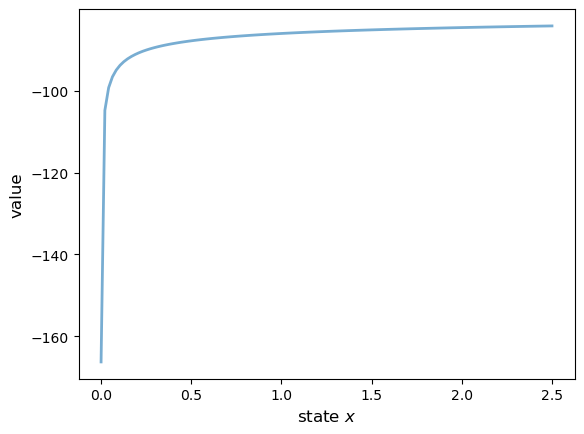

In [21]:
def compute_value_function_extended(model,
                                    tol=1e-4,
                                    max_iter=1000,
                                    verbose=True,
                                    print_skip=25):
    """
    Compute value function for extended cake model.
    """
    v = np.zeros(len(model.x_grid))
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_new = T_extended(v, model)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        v = v_new

    if error > tol:
        print("Failed to converge!")
    elif verbose:
        print(f"\nConverged in {i} iterations.")

    return v_new

v = compute_value_function_extended(model, verbose=False)

fig, ax = plt.subplots()

ax.plot(model.x_grid, v, lw=2, alpha=0.6)
ax.set_ylabel('value', fontsize=12)
ax.set_xlabel('state $x$', fontsize=12)

plt.show()

Here's the computed policy, combined with the solution we derived above for
the standard cake eating case $\alpha=1$.

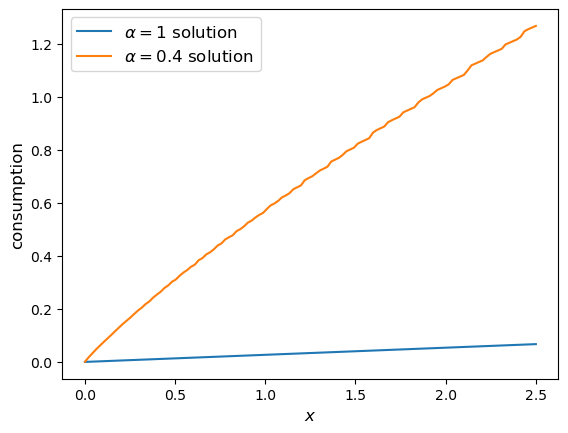

In [22]:
def σ_extended(model, v):
    """
    The optimal policy function for the extended cake model.
    """
    c = np.empty_like(v)

    for i in range(len(model.x_grid)):
        x = model.x_grid[i]
        c[i] = maximize(extended_state_action_value, 1e-10, x, (x, v, model))[0]

    return c

c_new = σ_extended(model, v)

# Get the baseline model for comparison
baseline_model = create_cake_eating_model()
c_analytical = c_star(baseline_model.x_grid, baseline_model.β, baseline_model.γ)

fig, ax = plt.subplots()

ax.plot(baseline_model.x_grid, c_analytical, label=r'$\alpha=1$ solution')
ax.plot(model.x_grid, c_new, label=fr'$\alpha={model.α}$ solution')

ax.set_ylabel('consumption', fontsize=12)
ax.set_xlabel('$x$', fontsize=12)

ax.legend(fontsize=12)

plt.show()

Consumption is higher when $\alpha < 1$ because, at least for large $x$, the return to savings is lower.

```{solution-end}
```